In [73]:
import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork, SequenceNetwork
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer

import numpy as np
import pickle
from SlovotvirModel import run_model, summary_func

In [51]:
RNG = np.random.default_rng(2023)

### 0. Setup and training

In [52]:
def model_prior():
    """Generates a random draw from the joint prior."""

    a = RNG.uniform(0, 10)
    b = RNG.uniform(0, 10)
    t = RNG.lognormal(0, sigma=0.5)
    return np.array([a, b, t])

In [53]:
prior = Prior(prior_fun=model_prior, param_names=[r"a", r"b", r"t"])

In [54]:
prior_means, prior_stds = prior.estimate_means_and_stds()

In [55]:
simulator = Simulator(simulator_fun=run_model)

In [56]:
model = GenerativeModel(prior, simulator, name="SlovoTvir")

INFO:root:Performing 2 pilot runs with the SlovoTvir model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


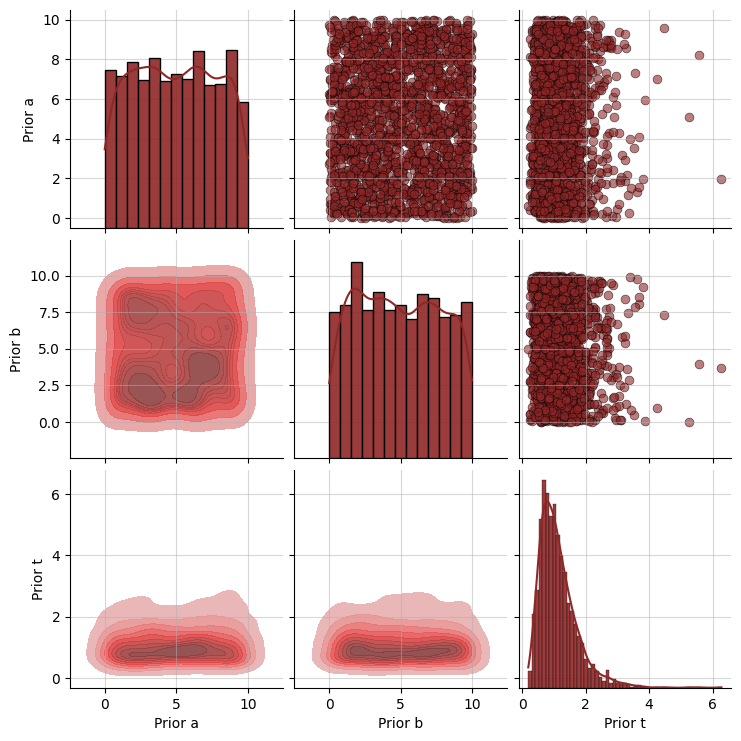

In [57]:
# As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
f = prior.plot_prior2d()

In [58]:
summary_net = SequenceNetwork()

In [59]:
inference_net = InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=4)

In [60]:
amortizer = AmortizedPosterior(inference_net, summary_net, name="slovotvir_amortizer")

In [61]:
def configure_input(forward_dict):
    """Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """

    # Prepare placeholder dict
    out_dict = {}

    # Convert data to logscale
    logdata = np.log1p(forward_dict["sim_data"]).astype(np.float32)

    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict["prior_draws"].astype(np.float32)
    params = (params - prior_means) / prior_stds

    # Add to keys
    out_dict["summary_conditions"] = logdata
    out_dict["parameters"] = params

    out_dict["summary_conditions"] = np.expand_dims(out_dict["summary_conditions"], axis=2)

    return out_dict

In [62]:
x = configure_input(model(1))

In [63]:
x['summary_conditions'].shape

(1, 6, 1)

In [64]:
trainer = Trainer(amortizer=amortizer, generative_model=model, configurator=configure_input, memory=True)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [65]:
amortizer.summary()

Model: "slovotvir_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_1 (Inve  multiple                  292936    
 rtibleNetwork)                                                  
                                                                 
 sequence_network_1 (Sequen  multiple                  91178     
 ceNetwork)                                                      
                                                                 
Total params: 384114 (1.47 MB)
Trainable params: 384090 (1.47 MB)
Non-trainable params: 24 (96.00 Byte)
_________________________________________________________________


In [66]:
%%time
_ = model(1000)

CPU times: user 5min 31s, sys: 2.52 s, total: 5min 33s
Wall time: 5min 43s


In [67]:
%%time
history = trainer.train_offline(_, epochs=30, batch_size=32, validation_sims=100)

INFO:root:Generated 20 simulations for validation.


Training epoch 1:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 4.855


Training epoch 2:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 4.903


Training epoch 3:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 4.958


Training epoch 4:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 5.009


Training epoch 5:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 5.079


Training epoch 6:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 5.147


Training epoch 7:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 5.210


Training epoch 8:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 5.294


Training epoch 9:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 5.350


Training epoch 10:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 5.410


Training epoch 11:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 5.478


Training epoch 12:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 5.551


Training epoch 13:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 5.606


Training epoch 14:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 5.676


Training epoch 15:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 5.735


Training epoch 16:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 5.778


Training epoch 17:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 5.811


Training epoch 18:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 5.822


Training epoch 19:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 5.832


Training epoch 20:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 5.848


Training epoch 21:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 5.859


Training epoch 22:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 5.865


Training epoch 23:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 5.870


Training epoch 24:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 5.877


Training epoch 25:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 5.881


Training epoch 26:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 5.885


Training epoch 27:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 5.889


Training epoch 28:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 5.890


Training epoch 29:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 5.891


Training epoch 30:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 5.891


CPU times: user 1min 20s, sys: 1.67 s, total: 1min 21s
Wall time: 1min 31s


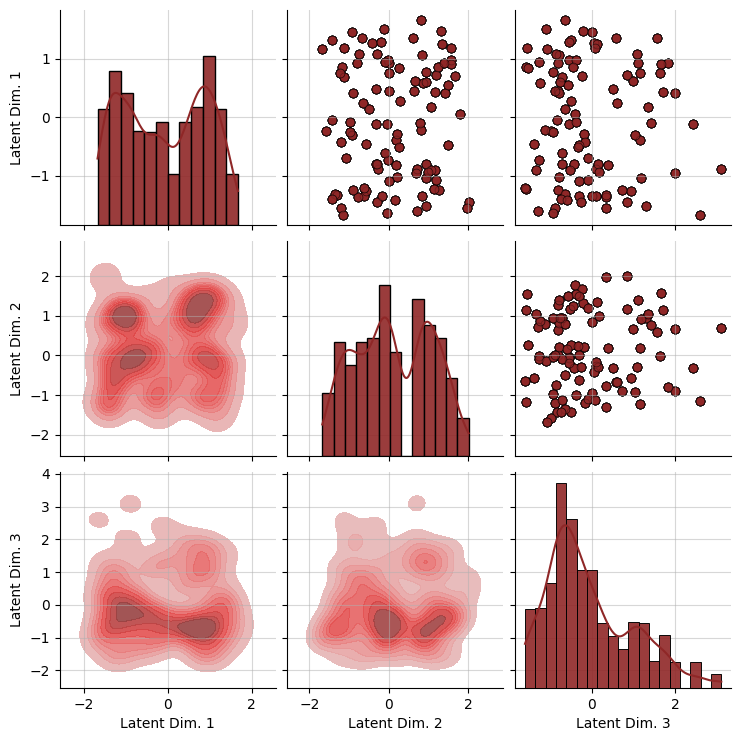

In [68]:
f = trainer.diagnose_latent2d()

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 19.                    Confidence intervals might be unreliable!


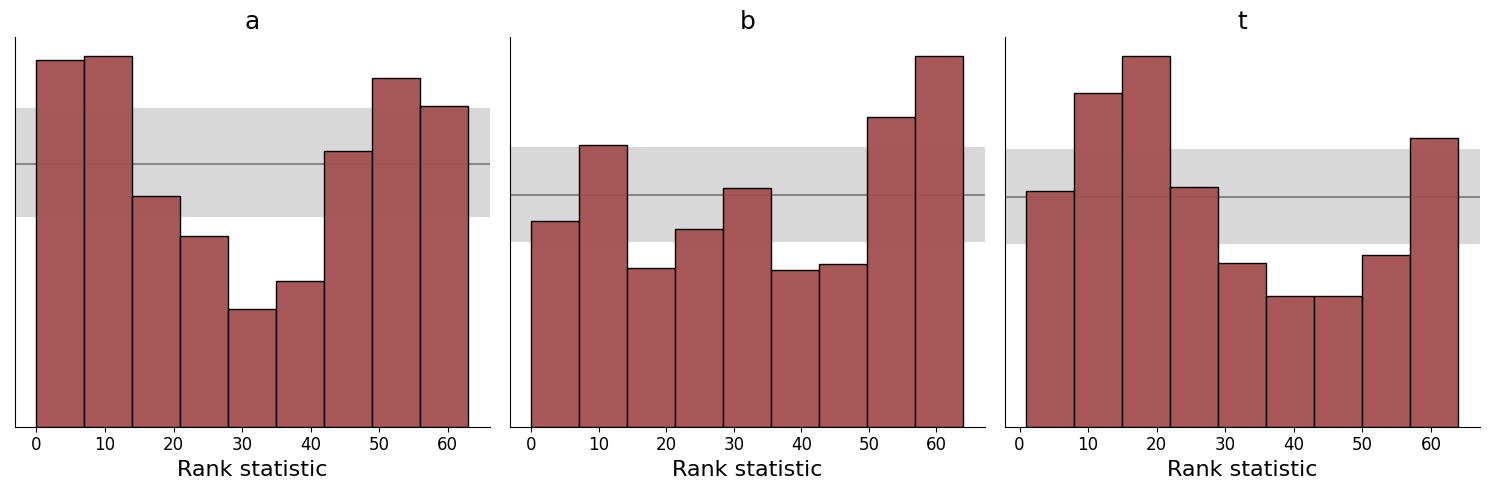

In [70]:
f = trainer.diagnose_sbc_histograms()

### 1. Posterior estimation:

In [74]:
with open('../data/true_likes.pkl', 'rb') as f:
    true_likes = pickle.load(f)

In [75]:
# Format data into a 3D array of shape (1, n_time_steps, 1) and perform log transform
obs_data = np.log1p(summary_func(true_likes))[np.newaxis, :, np.newaxis].astype(np.float32)

In [78]:
# Obtain 500 posterior draws given real data
post_samples = amortizer.sample({"summary_conditions": obs_data}, 500)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples = prior_means + post_samples * prior_stds

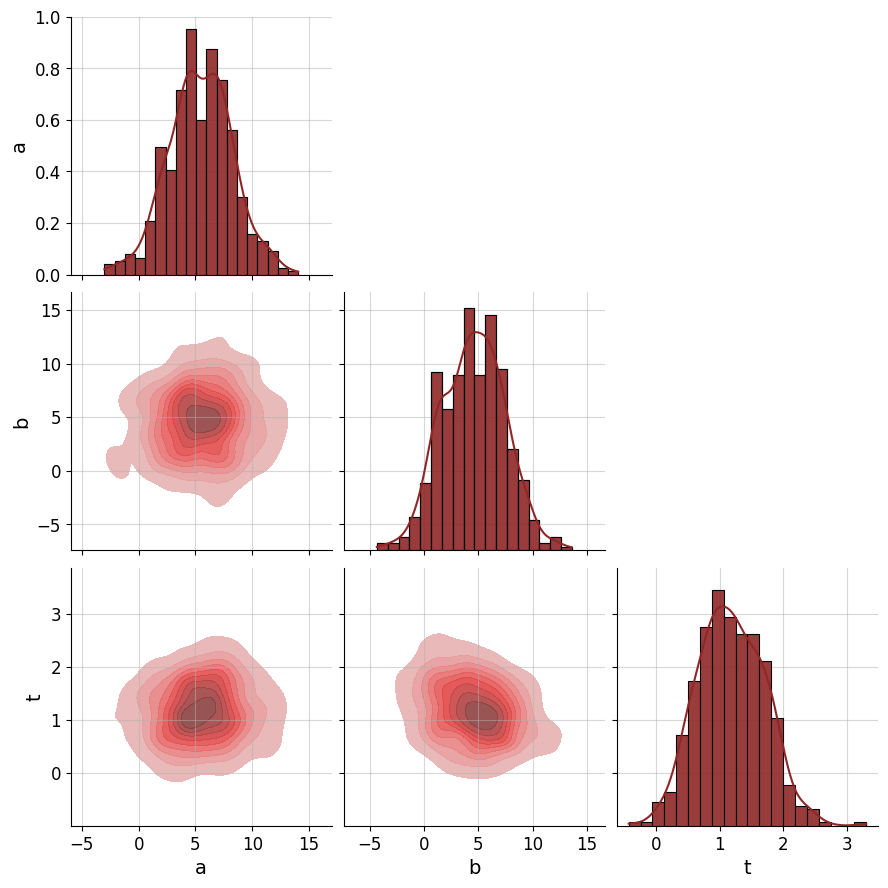

In [79]:
f = diag.plot_posterior_2d(post_samples, param_names=prior.param_names)

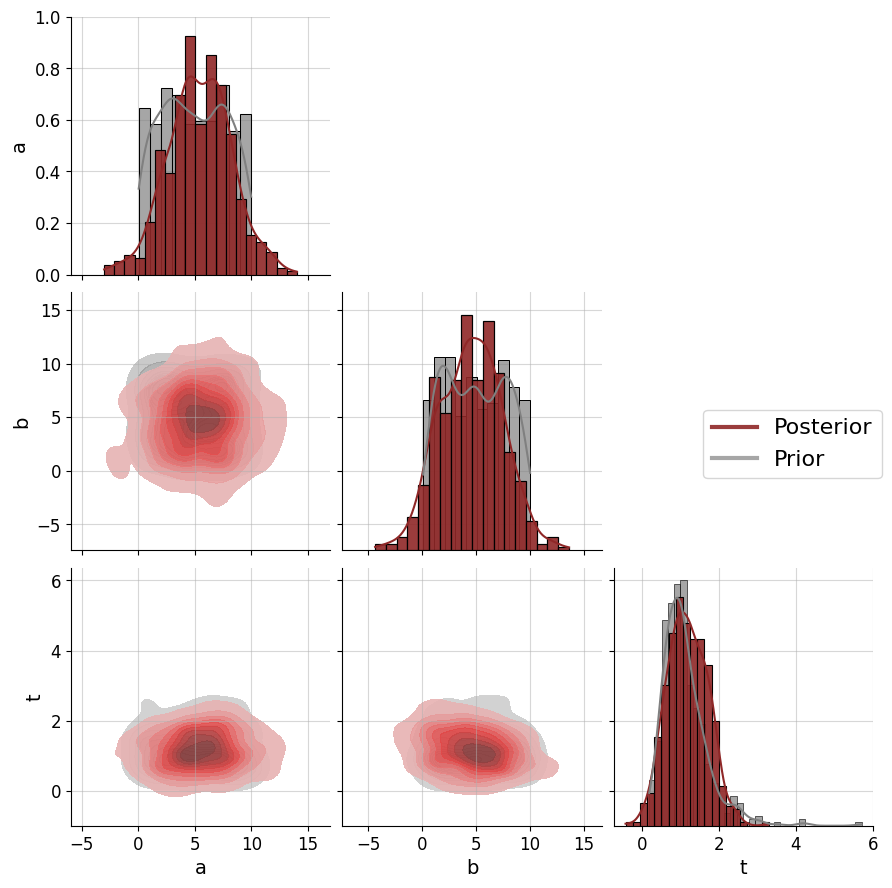

In [80]:
f = diag.plot_posterior_2d(post_samples, prior=prior)